# Import

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from scipy import signal

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


def r2_score(y_true, y_pred, ts):
    mu = np.mean(ts)
    total = np.sum((y_true - mu) ** 2)
    residuals = np.sum((y_true - y_pred) ** 2)
    return 1 - (residuals / total)


def absolute_percentage_error(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_pred)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(absolute_percentage_error(y_true, y_pred))


def max_absolute_percentage_error(y_true, y_pred):
    return np.max(absolute_percentage_error(y_true, y_pred))


def total_absolute_percentage_error(y_true, y_pred):
    return np.sum(absolute_percentage_error(y_true, y_pred))


def evaluate(y_true, y_pred, ts):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAD': median_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred, ts),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'MAXAPE': max_absolute_percentage_error(y_true, y_pred),
        'TAPE': total_absolute_percentage_error(y_true, y_pred)
    }

from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.nonparametric.smoothers_lowess import lowess


from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Preparation

leggo il dataset ed indicizzo per data usando il campo "Date"

In [32]:
class_name = 'Occupancy'

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')

dataset_path="/content/drive/Shared drives/DM2/files/timesplit.csv"
df = pd.read_csv(dataset_path, parse_dates=True, index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df.head()

#del df['Hour']
#del df['Day']
#del df['TimeSlot']
#del df['Weekend']
#del df['WorkingHour']

#del df['Temperature']
#del df['Humidity']
#del df['Light']
#del df['CO2']
#del df['HumidityRatio']


df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'




df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Date,,,,,,
2015-02-04 17:51:00,14.366102,9.401978,6.015908,4.966792,10.917095,Yes
2015-02-04 18:21:00,12.946071,9.536512,2.000000,4.461107,10.473336,No
2015-02-04 18:51:00,11.881048,9.484948,2.000000,4.055597,9.991500,No
2015-02-04 19:21:00,11.466872,9.351351,2.000000,3.579564,9.693679,No
2015-02-04 19:51:00,10.549769,9.281037,2.000000,3.334335,9.267534,No
...,...,...,...,...,...,...
2015-02-10 07:21:00,5.816333,13.461217,2.000000,2.363035,11.231821,No
2015-02-10 07:51:00,5.816333,13.461217,2.000000,2.348610,11.231821,No
2015-02-10 08:21:00,5.816333,13.518641,2.000000,2.358227,11.282846,No


plotto la time series per la feature x

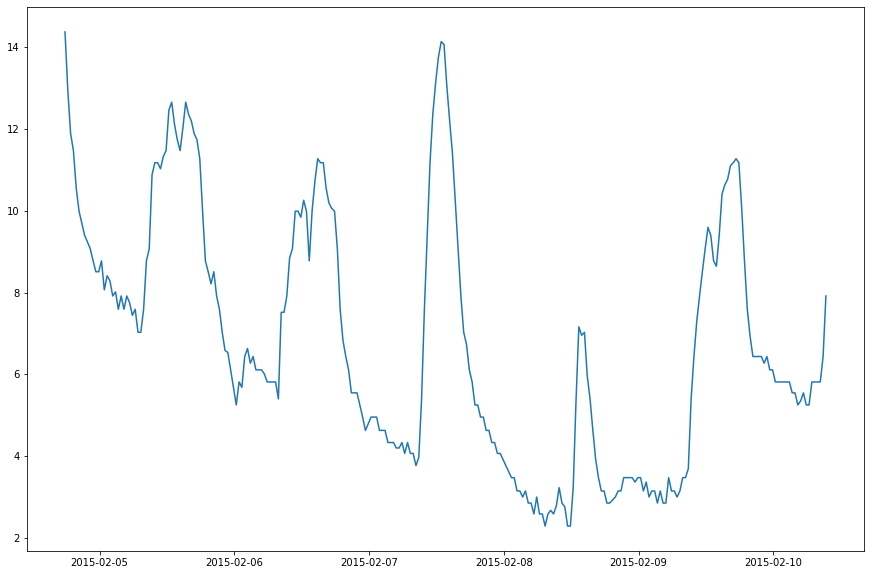

In [33]:
ts = df['Temperature']
plt.figure(figsize=(15,10))
plt.plot(ts)
plt.show()

In [34]:
index = pd.date_range(start=ts.index[0], end=ts.index[len(ts)-1], freq='30min')
print (index)


DatetimeIndex(['2015-02-04 17:51:00', '2015-02-04 18:21:00',
               '2015-02-04 18:51:00', '2015-02-04 19:21:00',
               '2015-02-04 19:51:00', '2015-02-04 20:21:00',
               '2015-02-04 20:51:00', '2015-02-04 21:21:00',
               '2015-02-04 21:51:00', '2015-02-04 22:21:00',
               ...
               '2015-02-10 04:51:00', '2015-02-10 05:21:00',
               '2015-02-10 05:51:00', '2015-02-10 06:21:00',
               '2015-02-10 06:51:00', '2015-02-10 07:21:00',
               '2015-02-10 07:51:00', '2015-02-10 08:21:00',
               '2015-02-10 08:51:00', '2015-02-10 09:21:00'],
              dtype='datetime64[ns]', length=272, freq='30T')


ristampo la time series

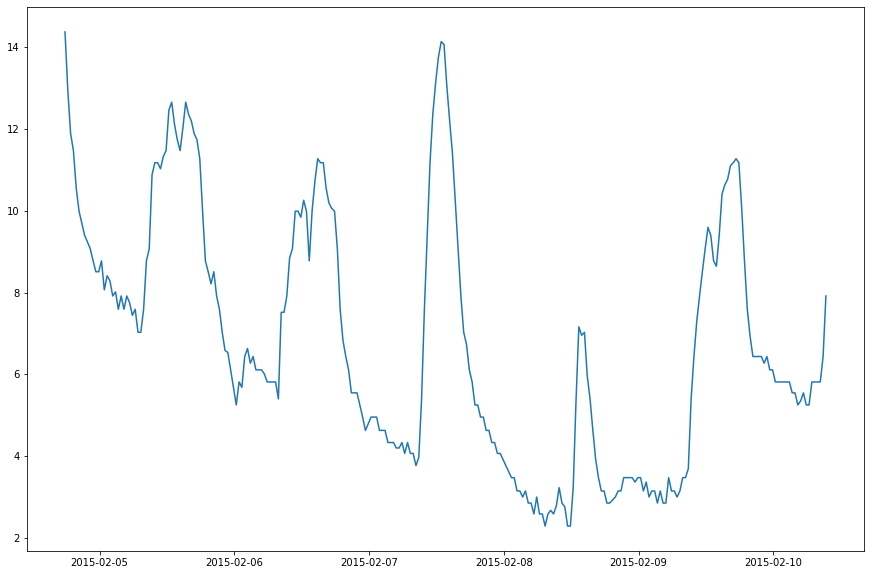

In [35]:
ts = pd.Series(ts.values, index)
plt.figure(figsize=(15,10))
plt.plot(ts)
plt.show()

# Time series elaboration

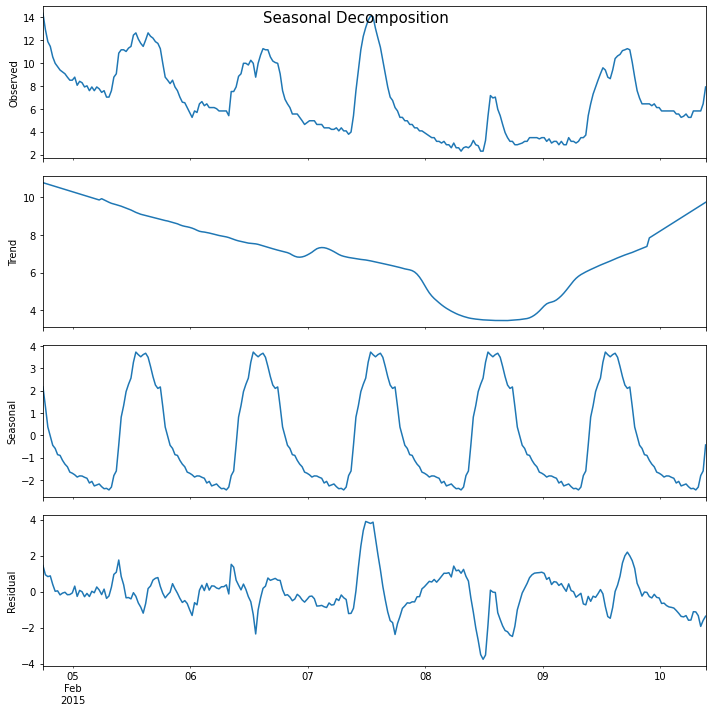

In [36]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(ts, model='multiplicative', freq=48, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ts, model='additive', freq=48, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Seasonal Decomposition', fontsize=15)
plt.show()

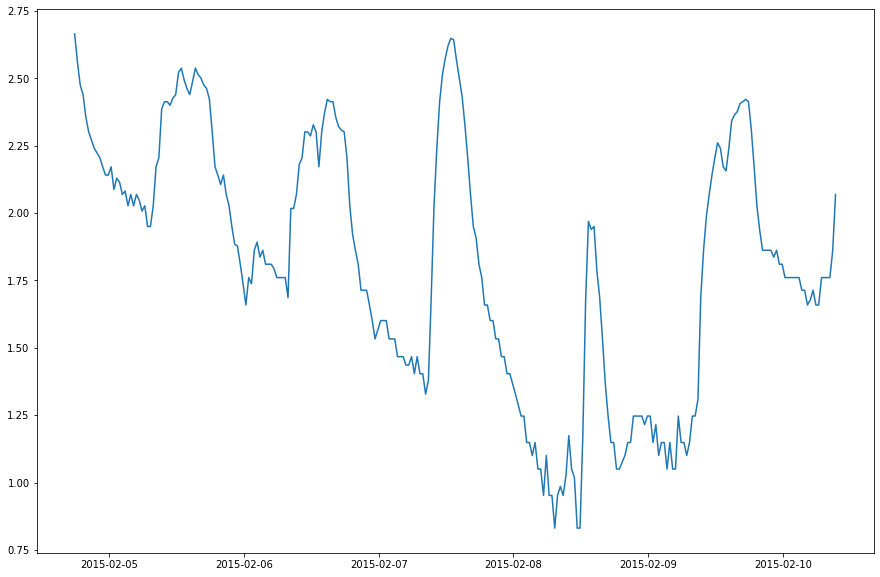

In [0]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.figure(figsize=(15,10))
plt.plot(ts_log)
plt.show()

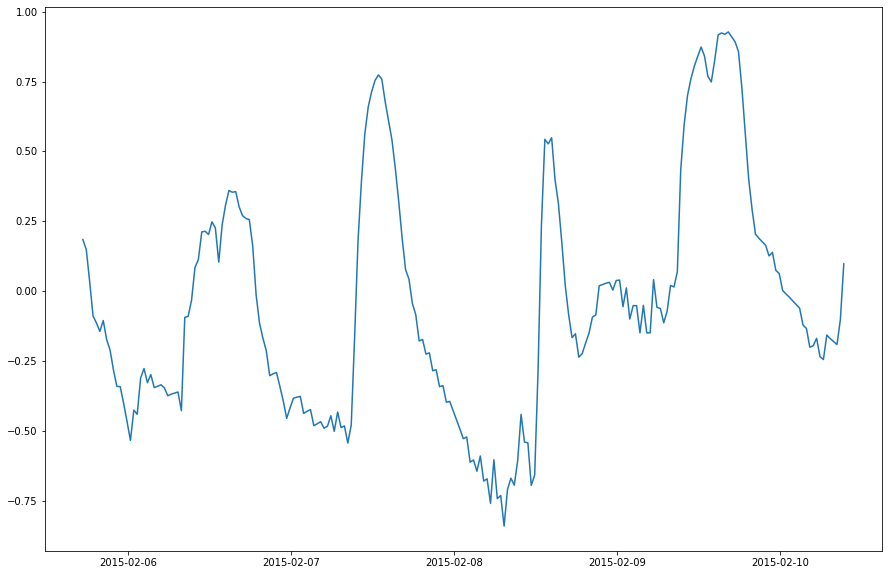

In [0]:
window = 48
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts.index)
ts_log_mov_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove all the NaN values
ts_log_mov_diff.dropna(inplace=True)
plt.figure(figsize=(15,10))
plt.plot(ts_log_mov_diff)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


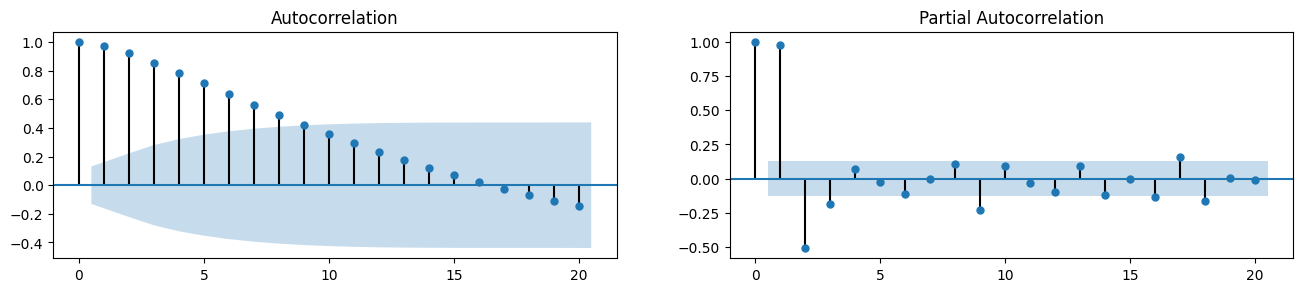

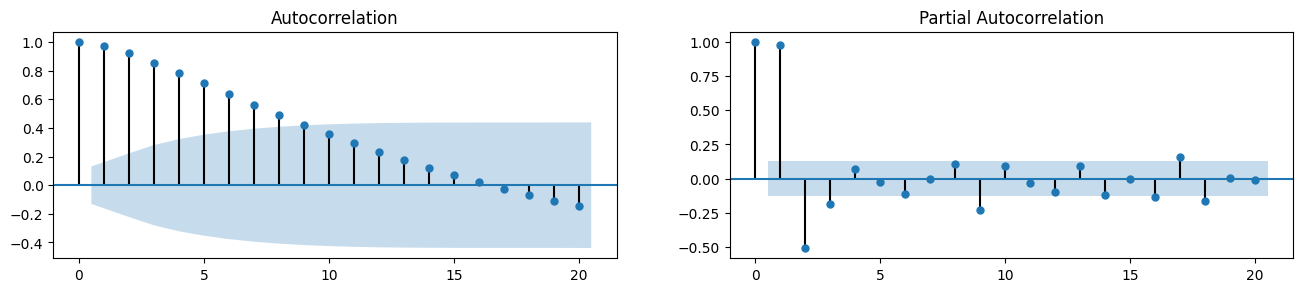

In [0]:
acf_50 = acf(ts_log_mov_diff.values, nlags=20)
pacf_50 = pacf(ts_log_mov_diff.values, nlags=20)

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(ts_log_mov_diff.values.tolist(), lags=20, ax=axes[0])
plot_pacf(ts_log_mov_diff.values.tolist(), lags=20, ax=axes[1])

In [0]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(ts_log_mov_diff, model='multiplicative', freq=48, extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(ts_log_mov_diff, model='additive', freq=48, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ValueError: ignored

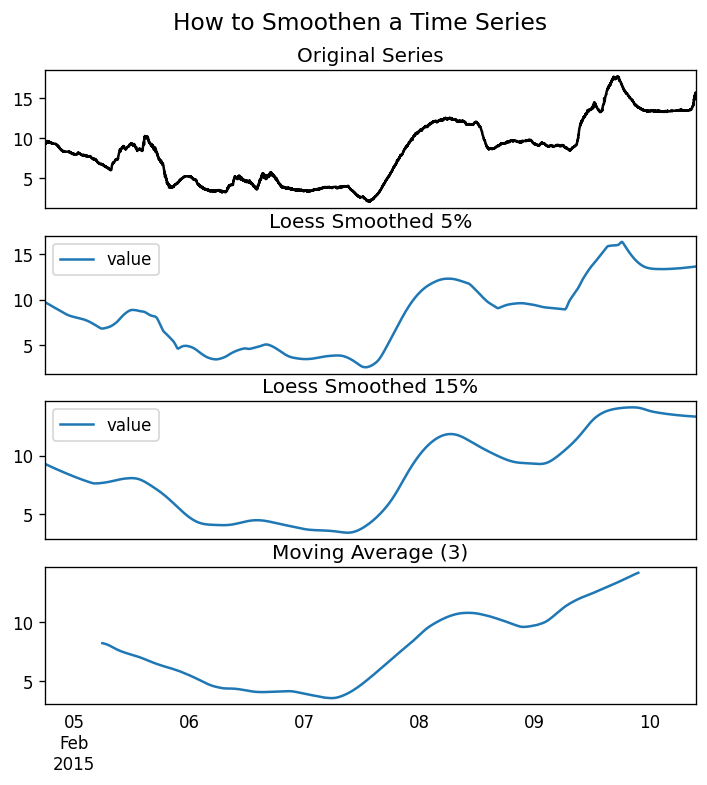

In [0]:

plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = ts.rolling(1440, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(ts.values, np.arange(len(ts.values)), frac=0.05)[:, 1], index=ts.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(ts.values, np.arange(len(ts.values)), frac=0.15)[:, 1], index=ts.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
ts.plot(ax=axes[0], color='k', title='Original Series')
df_loess_5.plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15.plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

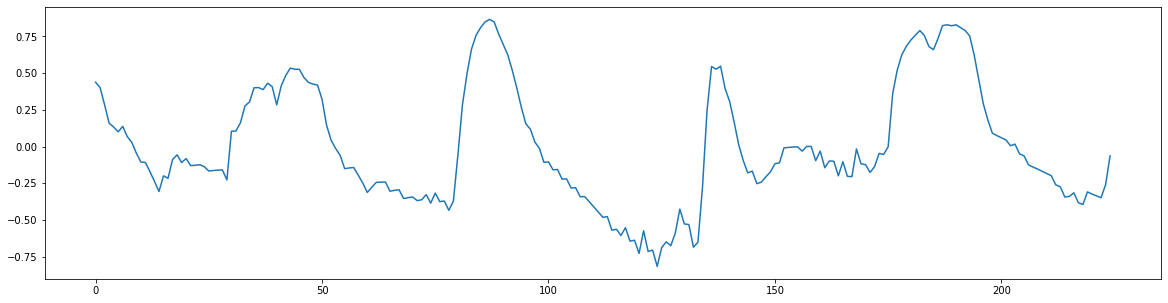

In [0]:
# Using scipy: Subtract the line of best fit

detrended = signal.detrend(ts_log_mov_diff.values)
plt.figure(figsize=(20,5))
plt.plot(detrended)

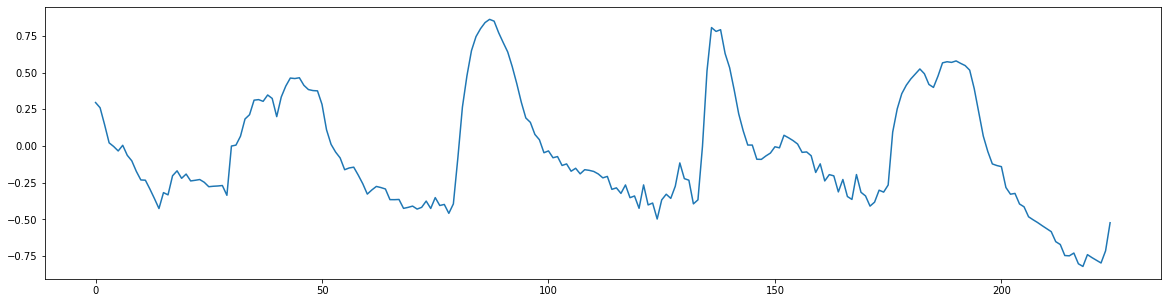

In [0]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
#detrended = pd.Series(detrended, index)
result_mul = seasonal_decompose(detrended, model='additive', freq=48, extrapolate_trend='freq')
ts2 = detrended - result_mul.trend
plt.figure(figsize=(20,5))
plt.plot(ts2)

In [0]:
dftest = adfuller(detrended, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.551935
p-value                          0.006749
#Lags Used                       2.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


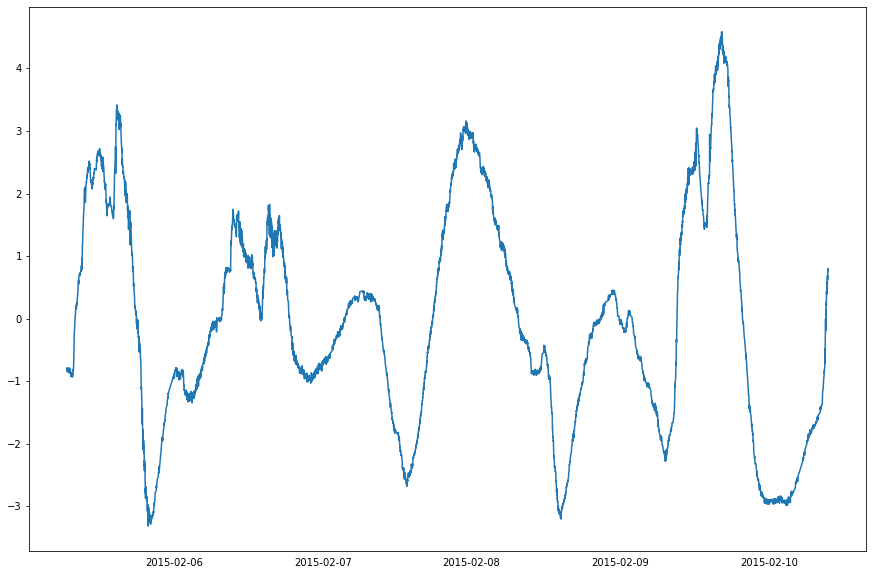

In [0]:
window = 770
ts_log_mov_diff = pd.Series(ts2 - ts2.rolling(window, center=False).mean(), index=ts2.index)
plt.figure(figsize=(15,10))
plt.plot(ts_log_mov_diff)
plt.show()

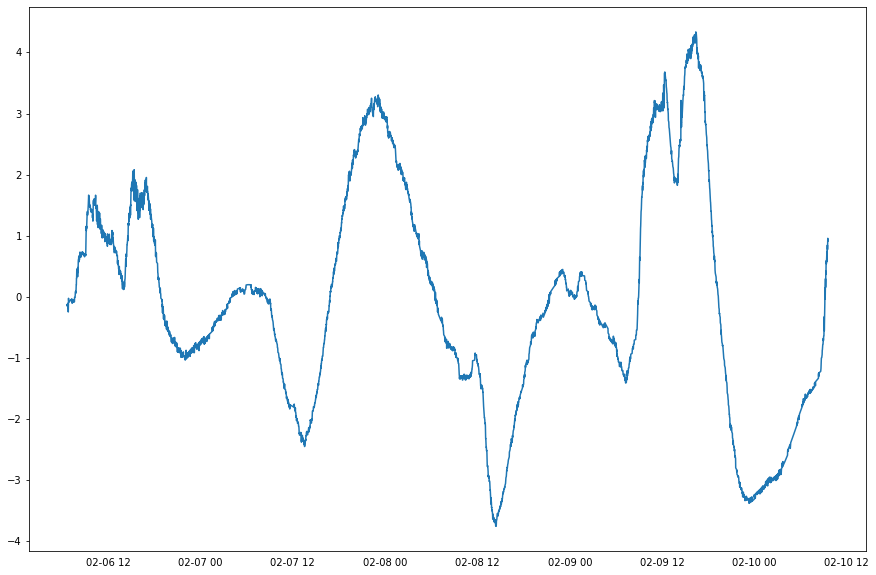

In [0]:
window = 1440
ts_log_mov_diff = pd.Series(ts_log_mov_diff - ts_log_mov_diff.rolling(window, center=False).mean(), index=ts_log_mov_diff.index)
# Transform the dataframe:
# Replace infs with NaN
ts_log_mov_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove all the NaN values
ts_log_mov_diff.dropna(inplace=True)

plt.figure(figsize=(15,10))
plt.plot(ts_log_mov_diff)
plt.show()

In [0]:
dftest = adfuller(ts_log_mov_diff, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.001573
p-value                           0.034748
#Lags Used                       31.000000
Number of Observations Used    5903.000000
Critical Value (1%)              -3.431458
Critical Value (5%)              -2.862030
Critical Value (10%)             -2.567031
dtype: float64


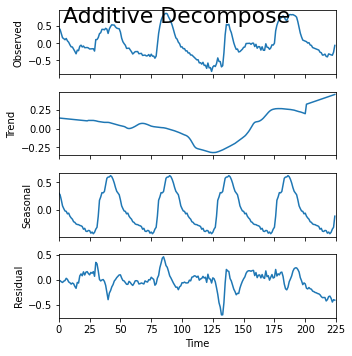

In [0]:
# Additive Decomposition
result_add = seasonal_decompose(detrended, model='additive', freq=48, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

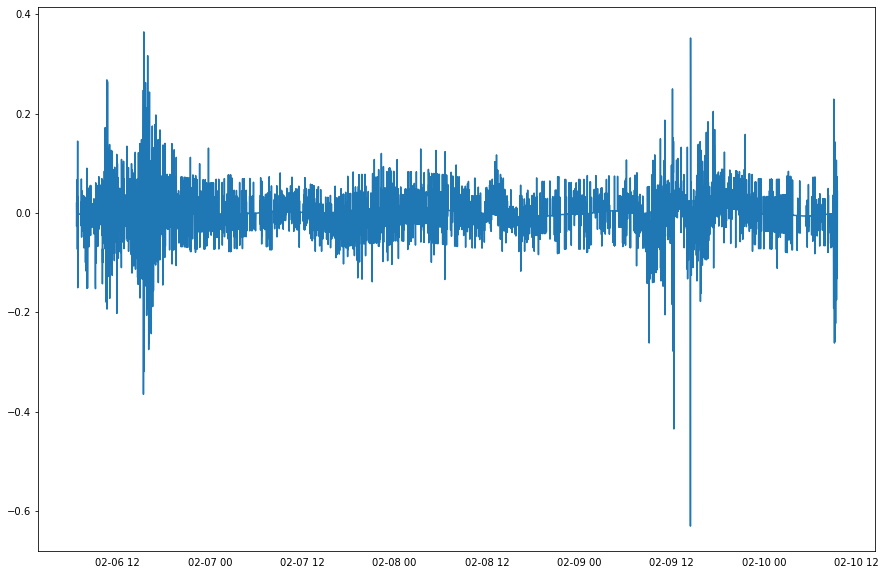

In [0]:
ts_diff = pd.Series(ts_log_mov_diff[:-1].values - ts_log_mov_diff[1:].values, index=ts_log_mov_diff.index[1:])
plt.figure(figsize=(15,10))
plt.plot(ts_diff)
plt.show()

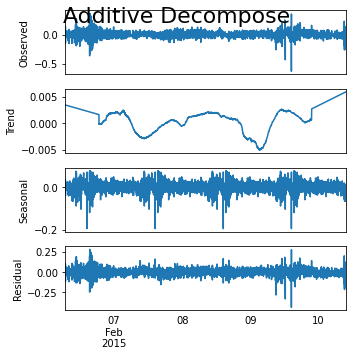

In [0]:
# Additive Decomposition
result_add = seasonal_decompose(ts_diff, model='additive', freq=1440, extrapolate_trend='freq')
# Plot
plt.rcParams.update({'figure.figsize': (5,5)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


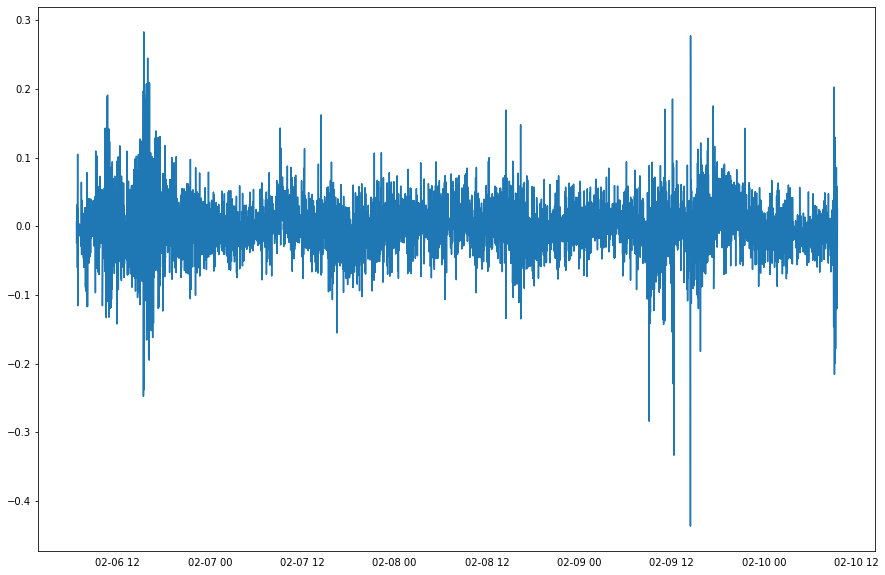

In [0]:
resi = pd.Series(result_add.resid, result_add.resid.index)

resi.replace([np.inf, -np.inf], np.nan, inplace=True)
# Remove all the NaN values
resi.dropna(inplace=True)

plt.figure(figsize=(15,10))
plt.plot(resi)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


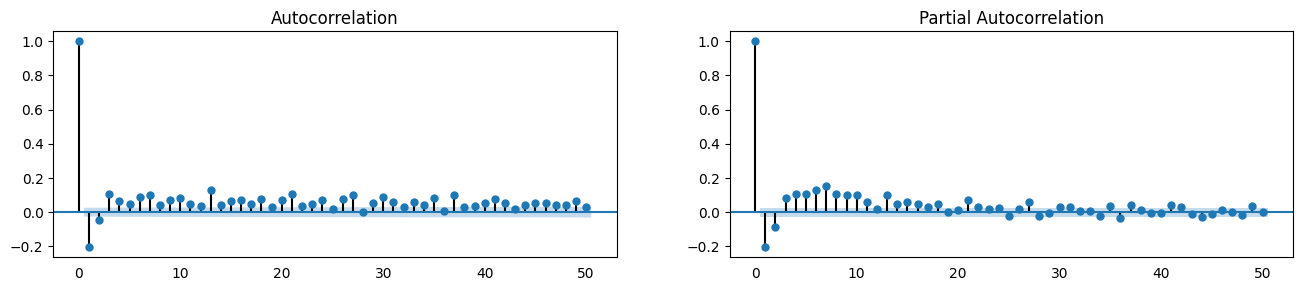

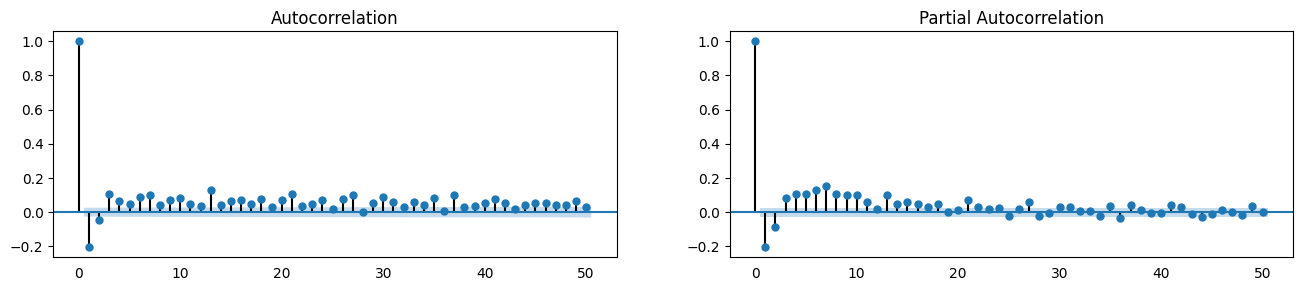

In [0]:
acf_50 = acf(ts_diff.values, nlags=50)
pacf_50 = pacf(ts_diff.values, nlags=50)

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(resi.values.tolist(), lags=50, ax=axes[0])
plot_pacf(resi.values.tolist(), lags=50, ax=axes[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


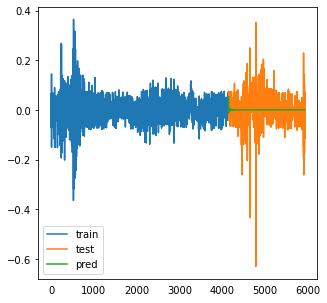

MAE 0.029
RMSE 0.050
MAD 0.013
R2 0.001
MAPE 14957.091
MAXAPE 2014630.276
TAPE 26638579.035


In [0]:
split_index = int (len(ts_diff)/100*70)
train, test = ts_diff.iloc[:split_index], ts_diff.iloc[split_index:]

arima = ARIMA(train, order=(3,1,10)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_diff).items():
    print('%s %.3f' % (k, v))

In [0]:
split_index = int (len(ts_diff)/100*70)
train, test = ts_diff.iloc[:split_index], ts_diff.iloc[split_index:]

sarimax = SARIMAX(train, order=(1,0,0), seasonal_order=(1, 0, 0, 1440)).fit(disp=False)
pred_train = sarimax.predict(start=train.index[0], end=train.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(train, pred_train, ts_diff).items():
    print('%s %.3f' % (k, v))

In [0]:
print (pred)

2015-02-09 03:53:00    0.007520
2015-02-09 03:54:00    0.007526
2015-02-09 03:55:00    0.007531
2015-02-09 03:56:00    0.007537
2015-02-09 03:57:00    0.007543
                         ...   
2015-02-10 09:29:00    0.017357
2015-02-10 09:30:00    0.017363
2015-02-10 09:31:00    0.017368
2015-02-10 09:32:00    0.017374
2015-02-10 09:33:00    0.017379
Freq: T, Length: 1781, dtype: float64


### Log Tranformation

applico la trasformazione logaritmica, differenziale e logaritmica media

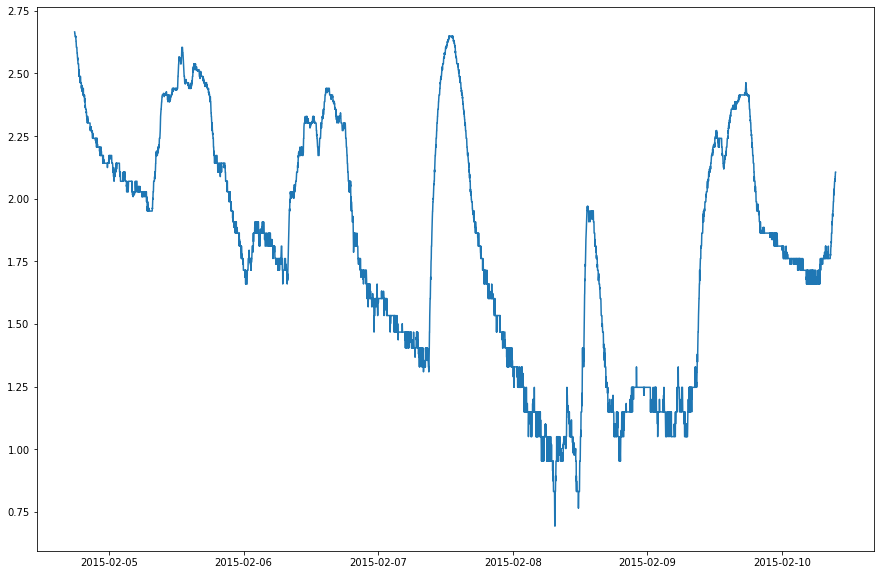

In [0]:
ts_log = pd.Series(np.log(ts), index=ts.index)
plt.figure(figsize=(15,10))
plt.plot(ts_log)
plt.show()

### Diff Tranformation

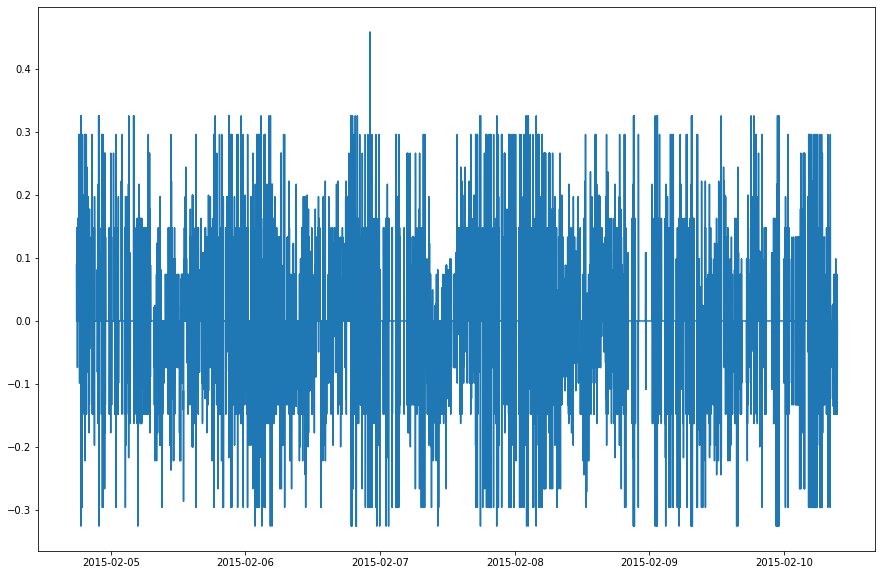

In [0]:
ts_diff = pd.Series(ts[:-1].values - ts[1:].values, index=ts.index[1:])
plt.figure(figsize=(15,10))
plt.plot(ts_diff)
plt.show()

### Log Mean Diff Tranformation

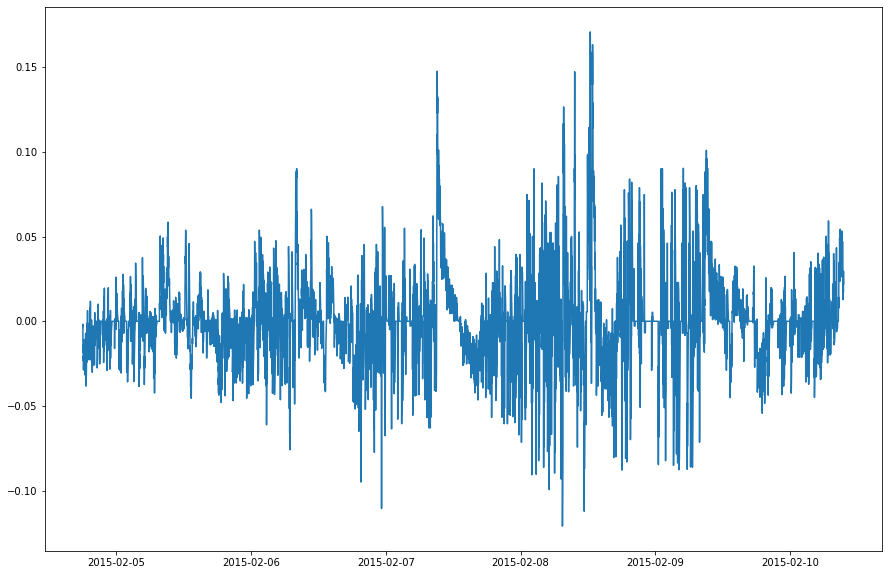

In [0]:
window = 12
ts_log_mov_diff = pd.Series(ts_log - ts_log.rolling(window, center=False).mean(), index=ts.index)
plt.figure(figsize=(15,10))
plt.plot(ts_log_mov_diff)
plt.show()

### Stationarity 


In [0]:
dftest = adfuller(ts, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.694434
p-value                           0.075006
#Lags Used                       21.000000
Number of Observations Used    8121.000000
Critical Value (1%)              -3.431155
Critical Value (5%)              -2.861896
Critical Value (10%)             -2.566959
dtype: float64


In [0]:
dftest = adfuller(ts_log, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -2.396276
p-value                           0.142790
#Lags Used                       25.000000
Number of Observations Used    8117.000000
Critical Value (1%)              -3.431156
Critical Value (5%)              -2.861896
Critical Value (10%)             -2.566960
dtype: float64


In [0]:
dftest = adfuller(ts_log_mov_diff.values[11:], autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.192035e+01
p-value                        5.049567e-22
#Lags Used                     2.000000e+01
Number of Observations Used    8.111000e+03
Critical Value (1%)           -3.431156e+00
Critical Value (5%)           -2.861896e+00
Critical Value (10%)          -2.566960e+00
dtype: float64


### Decomposition

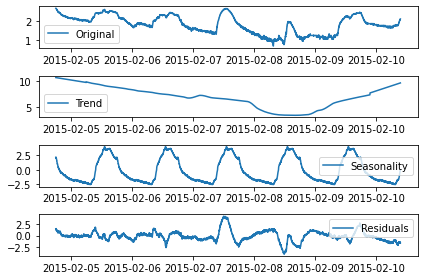

In [0]:
decomposition = seasonal_decompose(ts, freq=1440, extrapolate_trend='freq')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
residual.values
residual.value_counts(sort=True)

-1.731640    1
 0.001883    1
-0.404650    1
-0.317852    1
 0.230847    1
            ..
-0.858039    1
 0.445918    1
-0.629628    1
 0.030668    1
-1.832808    1
Length: 8143, dtype: int64

In [0]:
dftest = adfuller(residual.values, autolag='AIC')

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -4.186284
p-value                           0.000695
#Lags Used                       21.000000
Number of Observations Used    8121.000000
Critical Value (1%)              -3.431155
Critical Value (5%)              -2.861896
Critical Value (10%)             -2.566959
dtype: float64


# Forecasting

In [0]:
split_index = int (len(ts)/100*70)
train, test = ts.iloc[:split_index], ts.iloc[split_index:]

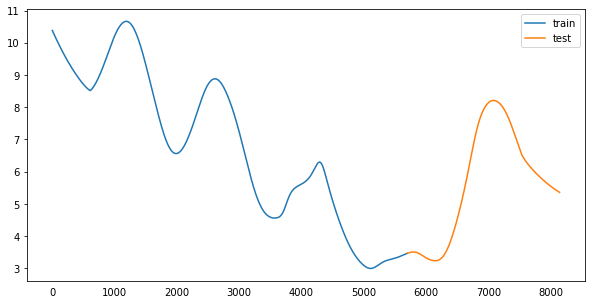

In [0]:
plt.plot(range(split_index), train, label='train')
plt.plot(range(split_index, len(ts)), test, label='test')
plt.legend()
plt.show()

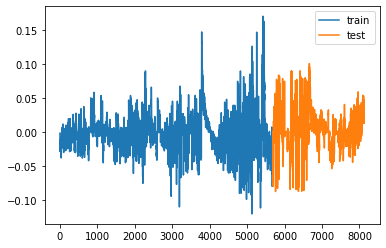

In [0]:
split_index = int (len(ts)/100*70)
train, test = ts_log_mov_diff.iloc[12:split_index], ts_log_mov_diff.iloc[split_index:]

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.legend()
plt.show()

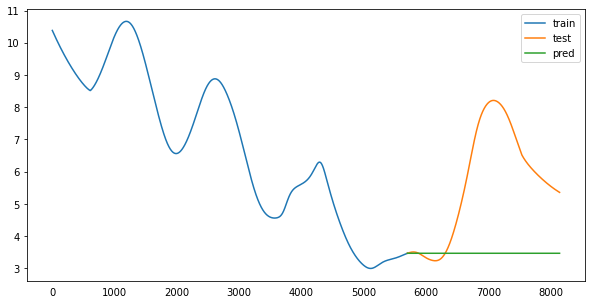

MAE 2.222
RMSE 2.775
MAD 2.290


TypeError: ignored

In [0]:
smoothing_level = 1
ses = SimpleExpSmoothing(train).fit(smoothing_level=smoothing_level, optimized=True)
pred = ses.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

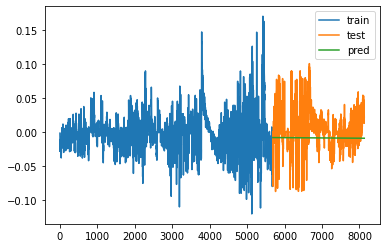

MAE 0.019
RMSE 0.027
MAD 0.011
R2 -0.177
MAPE 2.231
MAXAPE 12.692
TAPE 5450.670


In [0]:
smoothing_level=0.1
smoothing_slope=0.05

holt = Holt(train).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)
pred = holt.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

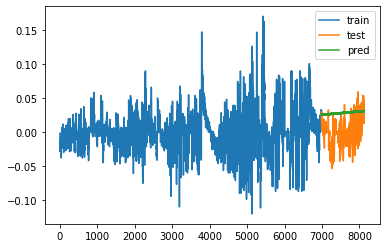

MAE 0.030
RMSE 0.033
MAD 0.028
R2 -3.002
MAPE 1.068
MAXAPE 3.034
TAPE 1220.252


In [0]:
seasonal_periods=12

es = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend='add', seasonal='add').fit()
pred = es.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

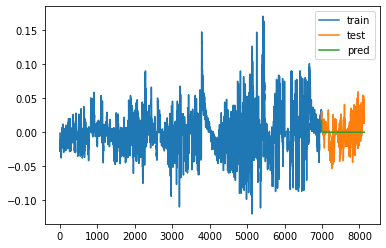

MAE 0.011
RMSE 0.017
MAD 0.006
R2 0.005
MAPE 40.933
MAXAPE 1917.656
TAPE 46786.129


In [0]:
arima = ARIMA(train, order=(1,0,0)).fit()
pred = arima.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

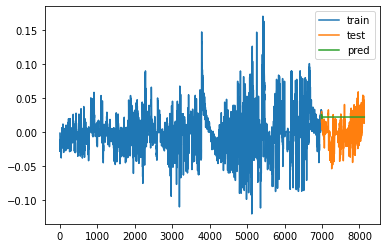

MAE 0.025
RMSE 0.028
MAD 0.022
R2 -1.896
MAPE 1.130
MAXAPE 3.459
TAPE 1291.464


In [0]:
sarimax = SARIMAX(train, order=(1,0,0), seasonal_order=(12, 1, 0, 1)).fit(disp=False)
pred = sarimax.predict(start=test.index[0], end=test.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train), len(train)+len(test)), test, label='test')
plt.plot(range(len(train), len(train)+len(pred)), pred, label='pred')
plt.legend()
plt.show()

for k, v in evaluate(test, pred, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

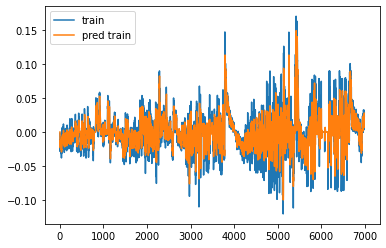

MAE 0.010
RMSE 0.017
MAD 0.005
R2 0.561
MAPE inf
MAXAPE inf
TAPE inf


In [0]:
pred_train = sarimax.predict(start=train.index[0], end=train.index[-1])

plt.plot(range(len(train)), train, label='train')
plt.plot(range(len(train)), pred_train, label='pred train')
plt.legend()
plt.show()

for k, v in evaluate(train, pred_train, ts_log_mov_diff).items():
    print('%s %.3f' % (k, v))

In [0]:
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 6988
Model:             SARIMAX(1, 0, 0)x(12, 1, 0, 1)   Log Likelihood               18390.295
Date:                            Mon, 04 May 2020   AIC                         -36752.591
Time:                                    13:44:39   BIC                         -36656.665
Sample:                                02-04-2015   HQIC                        -36719.533
                                     - 02-09-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2457      5.439     -0.045      0.964     -10.907      10.415
ar.S.L1       -0.2972      5.439   